In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''

!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d beinghasnain16/srgan-10000-images -p dataset
!unzip -q dataset/srgan-10000-images.zip -d dataset/srgan-10000-images
!rm dataset/srgan-10000-images.zip

Dataset URL: https://www.kaggle.com/datasets/beinghasnain16/srgan-10000-images
License(s): unknown
 97% 109M/112M [00:01<00:00, 145MB/s] 
100% 112M/112M [00:01<00:00, 116MB/s]


In [ ]:
import os
dir_dataset_hr =  '/content/dataset/srgan-10000-images/hr_images/hr_images'
files_img_hr = [os.path.join(dir_dataset_hr, x) for x in os.listdir(dir_dataset_hr)]
print(files_img_hr[0:5])

['/content/dataset/srgan-10000-images/hr_images/hr_images/11754.jpg', '/content/dataset/srgan-10000-images/hr_images/hr_images/8188.jpg', '/content/dataset/srgan-10000-images/hr_images/hr_images/15673.jpg', '/content/dataset/srgan-10000-images/hr_images/hr_images/9600.jpg', '/content/dataset/srgan-10000-images/hr_images/hr_images/4824.jpg']


In [ ]:
dir_dataset_lr =  '/content/dataset/srgan-10000-images/lr_images/lr_images'
files_img_lr = [os.path.join(dir_dataset_lr, x) for x in os.listdir(dir_dataset_lr)]
print(files_img_lr[0:5])

['/content/dataset/srgan-10000-images/lr_images/lr_images/11754.jpg', '/content/dataset/srgan-10000-images/lr_images/lr_images/8188.jpg', '/content/dataset/srgan-10000-images/lr_images/lr_images/15673.jpg', '/content/dataset/srgan-10000-images/lr_images/lr_images/9600.jpg', '/content/dataset/srgan-10000-images/lr_images/lr_images/4824.jpg']


In [ ]:
files_img_hr_test = files_img_hr[9984:]
files_img_hr = files_img_hr[0:9984]

files_img_lr_test = files_img_lr[9984:]
files_img_lr = files_img_lr[0:9984]

print(len(files_img_hr), len(files_img_lr), len(files_img_hr_test), len(files_img_lr_test))


9984 9984 16 16


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Function to display images in pairs
def show_image_pairs(image_paths):
    num_pairs = len(image_paths) // 2
    plt.figure(figsize=(6, num_pairs*2))

    for i in range(num_pairs):
        for j in range(2):
            image = cv2.imread(image_paths[i * 2 + j])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.subplot(num_pairs, 2, i * 2 + j + 1)
            plt.imshow(image)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

def downsample(img_file, scale=.25):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    img_small = cv2.resize(img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
    return img, img_small

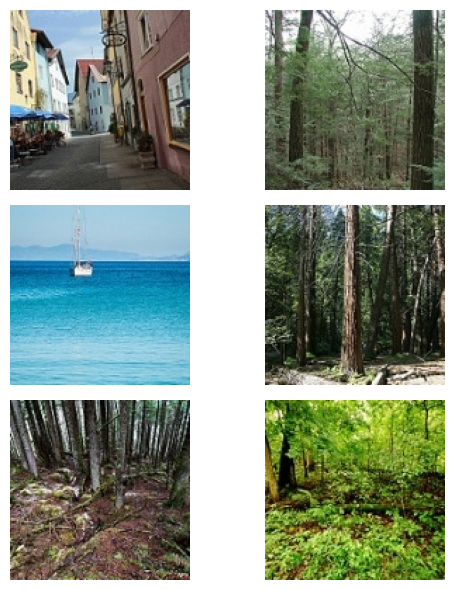

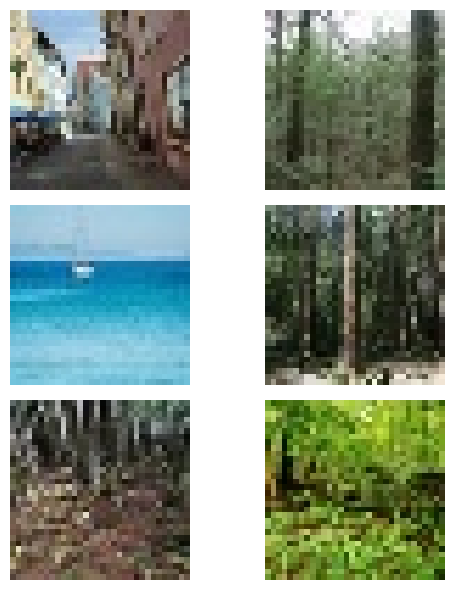

In [ ]:
show_image_pairs(files_img_hr[0:6])
show_image_pairs(files_img_lr[0:6])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, PReLU, UpSampling2D, Dense, Flatten, Input, add, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

import gc
from tensorflow.keras import backend as K

import numpy as np

In [ ]:
def residual_block(x):
    res = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    res = BatchNormalization(momentum=0.8)(res)
    res = PReLU(shared_axes=[1, 2])(res)
    res = Conv2D(64, kernel_size=3, strides=1, padding='same')(res)
    res = BatchNormalization(momentum=0.8)(res)
    return add([x, res])

In [ ]:
def build_generator():
    input_shape = (32, 32, 3)
    inputs = Input(input_shape)

    # First Convolutional Block
    gen = Conv2D(64, kernel_size=9, strides=1, padding='same')(inputs)
    gen = PReLU(shared_axes=[1, 2])(gen)
    gen_last = gen

    # Residual Blocks
    res = residual_block(gen)
    for _ in range(15):
        res = residual_block(res)

    # Second Convolutional Block
    gen = Conv2D(64, kernel_size=3, strides=1, padding='same')(res)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = add([gen, gen_last])

    # Upsampling Blocks
    for _ in range(2):
        gen = Conv2D(256, kernel_size=3, strides=1, padding='same')(gen)
        gen = Conv2DTranspose(1, (1, 1), (2, 2))(gen)
        gen = PReLU(shared_axes=[1, 2])(gen)

    # Final Output Block
    outputs = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(gen)

    return Model(inputs, outputs)

In [ ]:
def build_discriminator():
    input_shape = (128, 128, 3)
    inputs = Input(input_shape)

    disc = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    disc = LeakyReLU()(disc)

    disc = Conv2D(64, kernel_size=3, strides=2, padding='same')(disc)
    disc = BatchNormalization(momentum=0.8)(disc)
    disc = LeakyReLU()(disc)

    for filters in [128, 256, 512]:
        disc = Conv2D(filters, kernel_size=3, strides=1, padding='same')(disc)
        disc = BatchNormalization(momentum=0.8)(disc)
        disc = LeakyReLU()(disc)

        disc = Conv2D(filters, kernel_size=3, strides=2, padding='same')(disc)
        disc = BatchNormalization(momentum=0.8)(disc)
        disc = LeakyReLU()(disc)

    disc = Flatten()(disc)
    disc = Dense(1024)(disc)
    disc = LeakyReLU()(disc)
    outputs = Dense(1, activation='sigmoid')(disc)

    return Model(inputs, outputs)

In [ ]:
vgg_model = None # Declare vgg_model outside the function

def build_vgg():
    global vgg_model
    if vgg_model is None:
        vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
        vgg_model.trainable = False
        vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("block5_conv4").output)
    return vgg_model

def vgg_loss(y_true, y_pred):
    vgg = build_vgg()
    return tf.keras.losses.MeanSquaredError()(vgg(y_true),vgg(y_pred))

In [ ]:
def build_combined(generator, discriminator, vgg):
    discriminator.trainable = False
    inputs = Input((32, 32, 3))
    generated_img = generator(inputs)
    validity = discriminator(generated_img)
    return Model(inputs, [validity, generated_img])

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [ ]:
def compile_models(generator, discriminator, combined):
    optimizer = Adam(0.0002, 0.5)

    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    combined.compile(loss=["binary_crossentropy", vgg_loss], loss_weights=[1e-3, 1], optimizer=optimizer)

In [ ]:
# Assume `data_loader` yields low-res and high-res image pairs
epochs = 500
batch_size = 32
learning_rate = 0.0002

# create folders to save result images and trained models
img_save_dir = "/content/drive/MyDrive/Samples"
checkpoint_dir = "/content/drive/MyDrive/Models_SRGAN"

In [ ]:
dataset_lr = tf.keras.utils.image_dataset_from_directory(dir_dataset_lr, labels=None, image_size=(32, 32), batch_size=batch_size, shuffle=False)
dataset_hr = tf.keras.utils.image_dataset_from_directory(dir_dataset_hr, labels=None, image_size=(128, 128), batch_size=batch_size, shuffle=False)
dataset =  tf.data.Dataset.zip((dataset_lr, dataset_hr))

Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


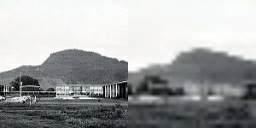

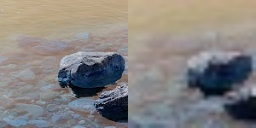

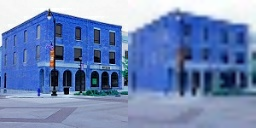

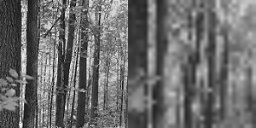

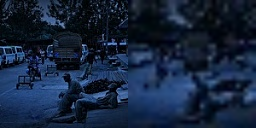

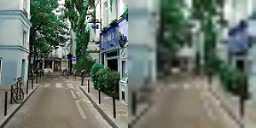

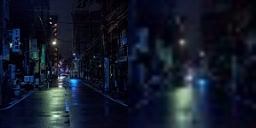

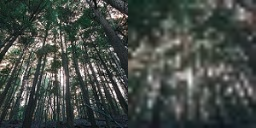

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

i = 0
for img_batch_lr, img_batch_hr in dataset:

    img_hr = img_batch_hr[0].numpy()
    img_lr = img_batch_lr[0].numpy()

    img_lr_resize = cv2.resize(img_lr, (img_hr.shape[0], img_hr.shape[1]))
    cv2_imshow(np.hstack([img_hr, img_lr_resize]))

    if i > 6:
      break

    i += 1

In [ ]:
def save_models(generator, epoch):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    generator_path = os.path.join(checkpoint_dir, f'generator_epoch_{epoch+1:03d}.h5')

    generator.save(generator_path)

    print(f"Saved generator model to {checkpoint_dir} after epoch {epoch+1}")

In [ ]:
from PIL import Image

if not os.path.exists(img_save_dir):
        os.makedirs(img_save_dir)

# @tf.function
def train(generator, discriminator, vgg, data_loader, epochs, batch_size):
    for epoch in range(7, epochs):
        for batch_i, (imgs_lr, imgs_hr) in enumerate(data_loader):

            # Train Discriminator
            fake_hr = generator(imgs_lr)
	          # Dynamically determine batch size
            current_batch_size = imgs_hr.shape[0]
            valid = np.ones((current_batch_size, 1))  # Use current_batch_size
            fake = np.zeros((current_batch_size, 1))  # Use current_batch_size

            d_loss_real = discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train Generator
            g_loss = combined.train_on_batch(imgs_lr, [valid, imgs_hr])

            print(batch_i)

        # Save progress
        print(f"E{epoch+1}: D Loss: {d_loss[0]}, G Loss: {g_loss[0]}")
        save_models(generator, epoch)
        img = cv2.imread(files_img_lr[9])
        img = np.expand_dims(img, axis=0) # add a batch
        img = generator(img)[0]
        img = Image.fromarray(np.uint8(img))
        img.save(os.path.join(img_save_dir, '{}_g_train_{}_batch.png'.format(epoch, batch_i)))
        show_image_pairs([files_img_hr[9], os.path.join(img_save_dir, '{}_g_train_{}_batch.png'.format(epoch, batch_i))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312
Epoch: 1, Batch: 313 D Loss: 0.48927587270736694, G Loss: 35.070220947265625
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 1


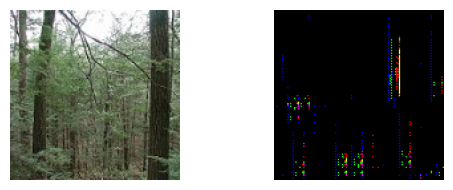

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 2, Batch: 313 D Loss: 0.48865777254104614, G Loss: 35.0019416809082
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 2


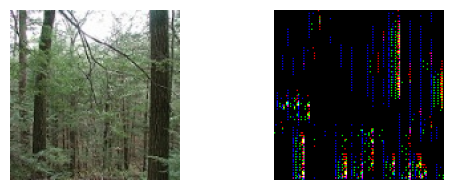

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 3, Batch: 313 D Loss: 0.4900302588939667, G Loss: 34.85700225830078
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 3


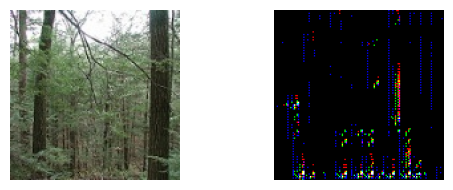

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 4, Batch: 313 D Loss: 0.4896547794342041, G Loss: 34.806785583496094
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 4


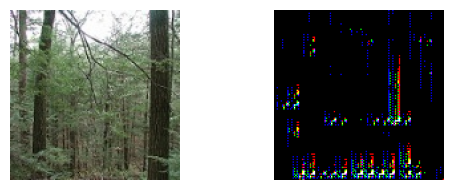

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 5, Batch: 313 D Loss: 0.4889916777610779, G Loss: 34.67684555053711
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 5


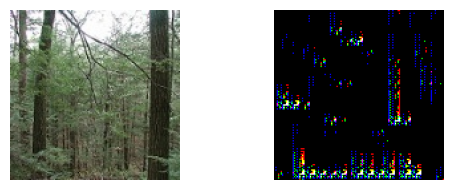

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 6, Batch: 313 D Loss: 0.4896443784236908, G Loss: 34.65699768066406
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 6


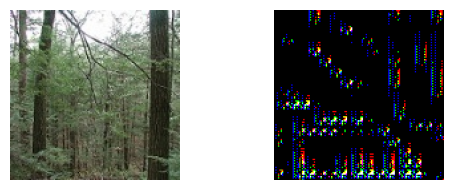

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
Epoch: 7, Batch: 313 D Loss: 0.48960113525390625, G Loss: 34.56083297729492
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 7


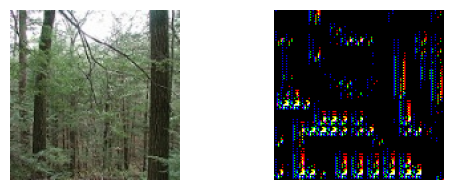

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [ ]:
generator = build_generator()
discriminator = build_discriminator()
vgg = build_vgg()

combined = build_combined(generator, discriminator, vgg)
compile_models(generator, discriminator, combined)

#Train from first epoch
train(generator, discriminator, vgg, dataset, epochs, batch_size)

80134624/80134624 [==============================] - 0s 0us/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312
E8: D Loss: 0.4767727255821228, G Loss: 34.602603912353516
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 8


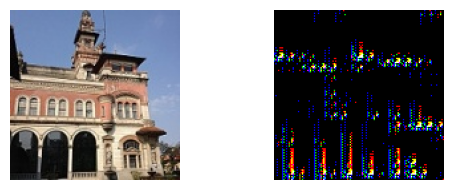

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
E9: D Loss: 0.47635725140571594, G Loss: 34.48320388793945
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 9


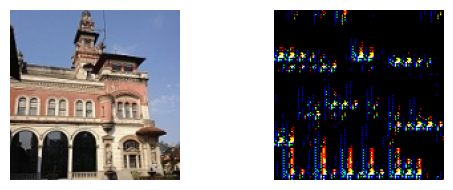

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

312
E10: D Loss: 0.47650229930877686, G Loss: 34.491397857666016
Saved generator model to /content/drive/MyDrive/Models_SRGAN after epoch 10


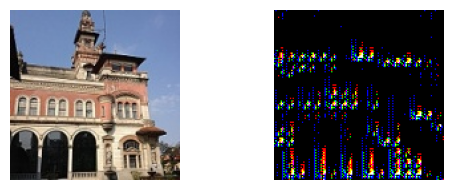

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import tensorflow as tf

num_epoch_saved = 7

# Path to your saved model
model_path = os.path.join(checkpoint_dir, f'generator_epoch_{num_epoch_saved:03d}.h5')

# Load the pre-trained SRGAN model
generator = tf.keras.models.load_model(model_path, compile=False)
discriminator = build_discriminator()
vgg = build_vgg()

combined = build_combined(generator, discriminator, vgg)
compile_models(generator, discriminator, combined)

#Train from specific epoch
train(generator, discriminator, vgg, dataset, epochs, batch_size)
